B4 einsum : torch.Size([1, 3, 2, 2, 128, 128])
Af einsum : torch.Size([1, 2, 2, 3, 128, 128])
torch.Size([3, 128, 128])


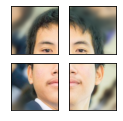

In [75]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch as th
from torch import nn
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
plt.rcParams["savefig.bbox"] = 'tight'
%matplotlib inline

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


transt = transforms.ToTensor()
transp = transforms.ToPILImage()
img_t = transt(Image.open('./moke.png'))

img_size = img_t.data.shape[1]
kernel_size = 128
n_patches = (img_size // kernel_size)

# patches = img_t.data.unfold(0, 3, 3).unfold(1, kernel_size, kernel_size).unfold(2, kernel_size, kernel_size)
patches = img_t.data.unfold(1, kernel_size, kernel_size).unfold(2, kernel_size, kernel_size)[None, ...]
print("B4 einsum :", patches.shape)
patches = torch.einsum('b c i j h w -> b i j c h w', patches)
print("Af einsum :", patches.shape)

print(patches[0][0][0].shape)

def visualize(n_patches, patches):
    """Imshow for Tensor."""    
    fig = plt.figure(figsize=(4, 4))
    for i in range(n_patches):
        for j in range(n_patches):
            inp = transp(patches[0][i][j])
            inp = np.array(inp)

            ax = fig.add_subplot(4, 4, ((i*4)+j)+1, xticks=[], yticks=[])
            plt.imshow(inp)

visualize(n_patches, patches)

X_patches :  torch.Size([2, 4, 3, 128, 128])
Y_patches :  torch.Size([2, 4, 3, 128, 128])
out shape :  torch.Size([2, 4, 3, 128, 128])
torch.Size([2, 2, 2, 3, 128, 128])
torch.Size([2, 3, 2, 128, 2, 128])
torch.Size([2, 3, 256, 256])
out shape :  torch.Size([2, 4, 3, 128, 128])
torch.Size([2, 2, 2, 3, 128, 128])
torch.Size([2, 3, 2, 128, 2, 128])
torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 256, 256]) torch.Size([2, 3, 256, 256])
tensor(True)
AdaptiveGN_Hadamart(
  (norm): ModuleList(
    (0): GroupNorm(3, 3, eps=1e-05, affine=True)
    (1): GroupNorm(3, 3, eps=1e-05, affine=True)
    (2): GroupNorm(3, 3, eps=1e-05, affine=True)
    (3): GroupNorm(3, 3, eps=1e-05, affine=True)
  )
)


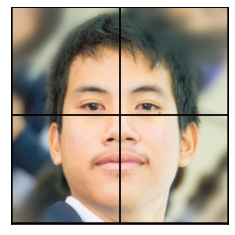

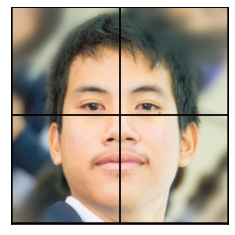

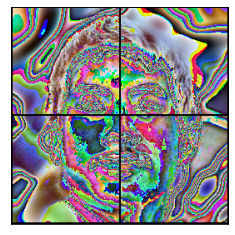

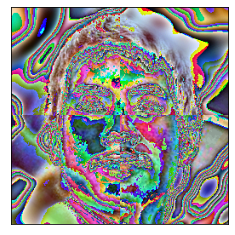

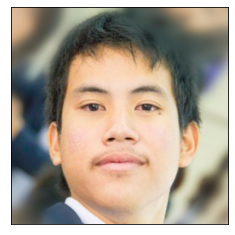

In [162]:
from tkinter import Scale
from unittest.mock import patch


def normalization(channels, n_group=32):
    """
    Make a standard normalization layer.

    :param channels: number of input channels.
    :return: an nn.Module for normalization.
    """
    return GroupNorm(n_group, channels)

class GroupNorm(nn.GroupNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)

class AdaptiveGN_Hadamart(nn.Module):
    def __init__(self, prep, channels, n_patches, image_size):
        super().__init__()
        self.prep = prep
        self.channels = channels
        self.image_size = image_size
        self.n_patches = n_patches
        self.patch_size = self.image_size // self.n_patches
        self.norm = nn.ModuleList([
            normalization(channels, n_group=3)
        ] * (self.n_patches**2))
        self.shift = 0
        
    def forward(self, x, y):
        #TODO: Implement fw-pass
        #NOTE: If want to do in a batch manner, need to create list of tensors with its length equal to len(norm)
        # e.g. [(B1 x C1 x H1 x W1), (B2 x C2 x H2 x W2), ..., (Bn x Cn x Hn x Wn)]; where n is n_patches ** 2
        #TODO: Is it worth to do, is it really faster?
        assert x.shape == y.shape
        b, c, h, w = x.shape
        x_patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x_patches = torch.einsum('b c i j h w -> b i j c h w', x_patches)
        # visualize(n_patches=self.n_patches, patches=patches)
        b, i, j, c, h, w = x_patches.shape
        x_patches = x_patches.reshape(b, -1, c, h, w)
        print("X_patches : ", x_patches.shape)
        grid = make_grid(x_patches[0], self.n_patches)
        show(grid)
        
        y_patches = y.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        y_patches = torch.einsum('b c i j h w -> b i j c h w', y_patches)
        # print(patches.shape)
        # visualize(n_patches=self.n_patches, patches=patches)
        b, i, j, c, h, w = y_patches.shape
        y_patches = y_patches.reshape(b, -1, c, h, w)
        print("Y_patches : ", y_patches.shape)
        grid = make_grid(y_patches[0], self.n_patches)
        show(grid)
        
        # Norm each patch
        out = th.zeros_like(x_patches)
        for i, norm in enumerate(self.norm):
            x_patches[0][i] = norm(x_patches[0][[i]])
            scale = y_patches[0][i]
            out[0][i] = (x_patches[0][i] * (1 + scale)) + self.shift
        
        grid = make_grid(out[0], self.n_patches)
        show(grid)
        final_out = self.patches_to_image(patches=out)
        y_back = self.patches_to_image(patches=y_patches)
        print(y_back.shape, y.shape)
        print((y_back == y).all())

        
    def patches_to_image(self, patches):
        print("out shape : ", patches.shape)
        b_p, n_p, c_p, h_p, w_p = patches.shape
        final_out = patches.reshape(b_p, self.n_patches, self.n_patches, c_p, h_p, w_p)
        print(final_out.shape)
        final_out = th.einsum('b i j c h w -> b c i h j w', final_out)
        print(final_out.shape)
        final_out = final_out.reshape(b_p, c_p, 256, 256)
        print(final_out.shape)
        grid = make_grid(final_out[0], self.n_patches)
        show(grid)
        return final_out
        
        
hadamart_layer = AdaptiveGN_Hadamart(prep='adaptive_gn', channels=3, n_patches=2, image_size=256)

img_1 = transt(Image.open('./moke.png'))
img_2 = transt(Image.open('./moke_2.png'))
img_1 = img_1.clone()[None, ...]
img_2 = img_2.clone()[None, ...]
hadamart_layer(x=th.cat((img_1, img_2), dim=0), y=th.cat((img_1, img_2), dim=0))
print(hadamart_layer)

In [58]:
d = torch.randn(10, 3, 105, 1024)
d = d.reshape(30, -1, -1)
d.shape

RuntimeError: only one dimension can be inferred

In [138]:
# 3328x2560
x = torch.randn(3328, 2560)
kh, kw = 256, 256 # kernel size
dh, dw = 256, 256 # stride
patches = x.unfold(0, kh, dh).unfold(1, kw, dw)
unfold_shape = patches.size()

patches = patches.contiguous().view(-1, kh, kw)
print(patches.shape)

# Reshape back
patches_orig = patches.view(unfold_shape)
output_h = unfold_shape[0] * unfold_shape[2]
output_w = unfold_shape[1] * unfold_shape[3]
patches_orig = patches_orig.permute(0, 2, 1, 3).contiguous()
patches_orig = patches_orig.view(output_h, output_w)

# Check for equality
print((patches_orig == x).all())


# 4084x3328
x = torch.randn(4084, 3328)
kh, kw = 256, 256 # kernel size
dh, dw = 256, 256 # stride
patches = x.unfold(0, kh, dh).unfold(1, kw, dw)
unfold_shape = patches.size()

patches = patches.contiguous().view(-1, kh, kw)
print(patches.shape)

# Reshape back
patches_orig = patches.view(unfold_shape)
output_h = unfold_shape[0] * unfold_shape[2]
output_w = unfold_shape[1] * unfold_shape[3] # you will lose some pixels in w
patches_orig = patches_orig.permute(0, 2, 1, 3).contiguous()
patches_orig = patches_orig.view(output_h, output_w)

# Check for equality using slicing, since w is now smaller in x
print((patches_orig == x[:output_h, :output_w]).all())

torch.Size([130, 256, 256])
tensor(True)
torch.Size([195, 256, 256])
tensor(True)
